* 信息熵（熵越高，数据越混乱）

$$
H=-\sum _{i=1}^{n} p(x_i) \log_2 p(x_i)
$$


In [2]:
# code: 3-1
from math import log  # 导入对数

def calc_shannon_ent(dataset):
    """
    计算信息增益
    :param dataset: 数据集
    :return : 信息熵
    """
    num = len(dataset)
    lab_num = {}
    # 为所有分类创建字典
    for feat in dataset:
        label = feat[-1]
        if label not in lab_num.keys():
            lab_num[label] = 0
        lab_num[label] += 1
    
    # 计算信息熵
    shannon_ent = 0.0
    for key in lab_num:
        prob = float(lab_num[key])/num
        shannon_ent -= prob * log(prob, 2)
    return shannon_ent

In [3]:
def create_dataset():
    dataset = [
        [1, 1, 'yes'],
        [1, 1, 'yes'],
        [1, 0, 'no'],
        [0, 1, 'no'],
        [0, 1, 'no'],
    ]
    lables = ['no surfacing', 'flippers']
    return dataset, lables

In [4]:
my_data, labels = create_dataset()
print(my_data)
print(labels)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
['no surfacing', 'flippers']


In [5]:
calc_shannon_ent(my_data)

0.9709505944546686

In [6]:
my_data[0][-1] = 'maybe'
my_data

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [7]:
calc_shannon_ent(my_data)

1.3709505944546687

In [8]:
# code: 3-2

def splite_data(dataset, axis, value):
    """
    分割数据
    :param dataset: 要分割的数据集
    :param axis: 维度，会删掉axis维的数据
    :param value: 该维度对应的值
    :return : 信息熵
    """
    res = []  # 创建的新的list对象
    for data in dataset:
        if data[axis] == value:
            # 跳过第i个属性值
            reduced_dataset = data[:axis]
            reduced_dataset.extend(data[axis + 1:])  # 追加
            res.append(reduced_dataset)
    return res

In [9]:
# 函数测试
my_data

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [10]:
splite_data(my_data, 1, 1)

[[1, 'maybe'], [1, 'yes'], [0, 'no'], [0, 'no']]

In [11]:
# code: 3-3

def choose_best_feat(dataset):
    """
    选择最好的分割属性
    :param dataset: 要分割的数据集
    :return : 属性i
    """
    feat_num = len(dataset[0]) - 1  # 特征数量
    base_entropy = calc_shannon_ent(dataset)
    best_info_gain = 0.0
    best_feature = -1
    for i in range(feat_num):
        # 创建第i个特征的列表
        feat_list = [example[i] for example in dataset]
        unique_vals = set(feat_list)  # 去掉重复值
        
        # 计算每种划分方式的信息熵
        new_entroy = 0.0
        for val in unique_vals:
            subdata = splite_data(dataset, i, val)
            prob = len(subdata)/float(len(dataset))
            new_entroy += prob * calc_shannon_ent(subdata)
        info_gain = base_entropy - new_entroy
        
        # 计算最好的信息熵
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = i
    return best_feature

In [12]:
my_data

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [13]:
choose_best_feat(my_data)

0

In [14]:
import operator

def majority_cnt(class_list):
    """
    获取类别最多的类标记
    :param class_list: 类别列表
    :return : 类别最多的类标记
    """
    class_count = {}
    for vote in class_list:
        if vote not in class_count.keys():
            class_count[vote] = 0
        class_count[vote] += 1
    sorted_class_count = sorted(class_count.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sorted_class_count[0][0]

In [15]:
# code: 3-4

def create_tree(dataset, labels):
    """
    创建树
    :param dataset: 数据集
    :param labels: 标签列表，包含在dataset中，但为了给出数据明确的含义，将他作为一个输入参数提供
    :return : 
    """
    class_list = [example[-1] for example in dataset]
    
    # 停止条件：所有的类标签完全相同
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]
    
    # 停止条件：使用完所有特征，仍不能将数据集正确划分
    if len(dataset[0]) == 1:
        return majority_cnt(class_list)
    
    best_feat = choose_best_feat(dataset)
    best_feat_label = labels[best_feat]
    my_tree = {best_feat_label:{}}
    
    # 得到列表包含的所有属性值
    del(labels[best_feat])
    feat_val = [example[best_feat] for example in dataset]
    unique_val = set(feat_val)
    
    for val in unique_val:
        sub_labels = labels[:]
        my_tree[best_feat_label][val] = create_tree(splite_data(dataset, best_feat, val), sub_labels)
        
    return my_tree

In [16]:
# test
my_data, labels = create_dataset()
myTree = create_tree(my_data, labels)
print('myTree: ', myTree)

myTree:  {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


In [25]:
# code:3-8
def classify(inputTree, featLabels, testVec):
    """
    决策树的分类函数
    """
    first_str = list(inputTree.keys())[0]
    # {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
    second_dict = inputTree[first_str]
    featIndex = featLabels.index(first_str) # 标签字符串转换为索引
    for key in second_dict.keys():`
        if testVec[featIndex] == key:
            if type(second_dict[key]).__name__=='dict':
                classLabel = classify(second_dict[key], featLabels, testVec)
            else:
                classLabel = second_dict[key]
    return classLabel
    

In [29]:
# test
import treePlotter
my_data, labels = create_dataset()
print(labels)
myTree = treePlotter.retrieve_tree(0)
print(myTree)
print(classify(myTree, labels, [1,0]))
print(classify(myTree, labels, [1,1]))

['no surfacing', 'flippers']
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
no
yes


In [33]:
# code 3-9
def storge_tree(input_tree, file_name):
    import pickle
    fw = open(file_name, 'wb')
    pickle.dump(input_tree, fw)
    fw.close()

def grab_tree(file_name):
    import pickle
    fr = open(file_name, 'rb')
    return pickle.load(fr)

In [34]:
storge_tree(myTree, 'ClassifierStorge.txt')
grab_tree('ClassifierStorge.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [35]:
fr = open('./dataset/lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = create_tree(lenses, lensesLabels)
lensesTree

{'tearRate': {'normal': {'astigmatic': {'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'young': 'hard',
        'presbyopic': 'no lenses'}},
      'myope': 'hard'}},
    'no': {'age': {'pre': 'soft',
      'young': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}}}}},
  'reduced': 'no lenses'}}

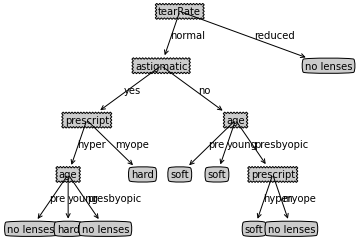

In [37]:
treePlotter.create_plot(lensesTree)